# Master Forgery

### Program to extract a high quality image of a signature or signatures from any image on plain white paper. Extracts images with a completely white background, and crops to remove most of the plain paper.

<br>

## Algorithm Process

### Step 1. Input
___
##### Use "cv2.imread()" to import an image using its file path.
##### Convert the image to RGB colourspace using "cv2.cvtColor()".
##### Get the hight and width of the image, and resize to four times the original size.
##### This is done to provide more pixels to work with for later steps, in case of small input images.
##### This will negatively impact performance, but it is worth it for a clearer output.

<br>

### Step 2. Smoothening
___
##### Define a kernel with surrounding numbers very close to the center number.
##### A kernel like this will blur the image. Apply the kernel as a 2D filter.
##### Combined with the up-size from Step 1, this smooths the image.

<br>

### Step 3. Magnitude
___
##### Use the Sobel function to extract gradients, from the blurred image.
##### Find the magnitude of the gradients using SQRT(Ix^2 + Iy^2).
##### The magnitude represents the magnitude of the change in values between pixels.

<br>

### Step 4. Crop
___
##### The next step is to crop the image down to size.
##### Cropping the image now instead of at the end means that further operations will be on a smaller image.
##### This should improve the performance.
##### In order to crop the image, a threshold is needed.
##### The idea is to find the highest, lowest, rightmost, and leftmost pixels with values above the threshold.
##### The algorithm then takes just the pixels within those bounds.
##### The threshold is calculated based on the mean value of the image, and bound to upper and lower values of 50 and 200.
##### The region to crop to is calculated based on the magnitude calculated in Step 3.
##### This provides strong values in areas with sharp changes (like text), and weaker values in other areas that only change gradually, or don't change at all.

<br>

### Step 5. Threshold
___
##### Now that the image is cropped to just the signature, thresholding ensures that the output will have black only on the signature, and a full white background.
##### The threshold to use is calculated based on the mean and standard deviation of the image.
##### The lack and white image resulting from the threshold operation is going to be a mask moving forward.

<br>

### Step 6. Colour Preservation
___
##### To better comply with the contract, I've added code to preserve the original colour of the signature on the paper.
##### The contract doesn't say to make the text black, just to make the background white and increase the quality.
##### To achieve this, I crop a copy of the original image down to the same size as the mask now is.
##### I create an opposite of the mask using "cv2.bitwise_not()", and mask it on the original image to get just the signature, on a black background.
##### Then I can add this image with the image of the original mask.
##### Because in the mask the text is black, and in the new image, everywhere but the text is black, the combined image gives us the original signature on a fully white background.

<br>

### Step 7. Re-sizing
___
##### Before outputting, the image needs to be shrank back down, as it was increased in size 4 times in Step 1, and this can result in excessive output sizes.
##### The target height and width are obtained by dividing the height and width of the image by 4.
##### To avoid an excessively small output (such as when a signature was only a small part of a larger image) the output size will have a minimum width of 512 pixels.
##### The image that comes from this operation is the final output, and is displayed by the program, as well as being exported as a PNG.

In [244]:
import cv2 as cv2
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import image as image

# Step 1 -----------------------------------------------------------
imageIn = cv2.imread("Boss.png")

imageIn = cv2.cvtColor(imageIn, cv2.COLOR_BGR2RGB)

imageOriginal = imageIn.copy()

h, w, d = imageIn.shape
imageIn = cv2.resize(imageIn, dsize=(4*w, 4*h))

In [245]:
# Step 2 -----------------------------------------------------------
blurKernel = np.array([[14,15,14], [15,16,15], [14,15,14]], dtype=float)/99

smooth = cv2.filter2D(imageIn,ddepth=-1,kernel=blurKernel)
smooth = cv2.filter2D(smooth,ddepth=-1,kernel=blurKernel)

In [246]:
# Step 3 -----------------------------------------------------------
grayScale = cv2.cvtColor(smooth, cv2.COLOR_RGB2GRAY)

Ix = cv2.Sobel(grayScale,ddepth=cv2.CV_64F,dx=1,dy=0)
Iy = cv2.Sobel(grayScale,ddepth=cv2.CV_64F,dx=0,dy=1)

magnitude = np.sqrt((Ix * Ix) + (Iy * Iy))

In [247]:
# Step 4 -----------------------------------------------------------
cropGuide = magnitude

# The values used here were calculated based on the relationships between
# the mean values of several images and their ideal threshold value.
cropThresh = round((np.mean(magnitude)*109.75382) - 256.583)

if cropThresh > 200:
    cropThresh = 200

if cropThresh < 50:
    cropThresh = 50

right = max(np.where(cropGuide > cropThresh)[1])
left = min(np.where(cropGuide > cropThresh)[1])
bottom = max(np.where(cropGuide > cropThresh)[0])
top = min(np.where(cropGuide > cropThresh)[0])

croppedImage = smooth[top:bottom, left:right]

In [248]:
# Step 5 -----------------------------------------------------------
imageYUV = cv2.cvtColor(croppedImage, cv2.COLOR_RGB2YUV)

brightness = imageYUV[:,:,0]

imgThresh = np.mean(brightness) - np.std(brightness)

imgThresh, mask = cv2.threshold(brightness, thresh = imgThresh, maxval = 255, type = cv2.THRESH_BINARY)

In [ ]:
# Step 6 -----------------------------------------------------------
croppedOriginal = imageIn[top:bottom, left:right]

mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
oppositeMask = cv2.bitwise_not(mask)

background = mask
foreground = cv2.bitwise_and(croppedOriginal, oppositeMask)

output = foreground + background

True

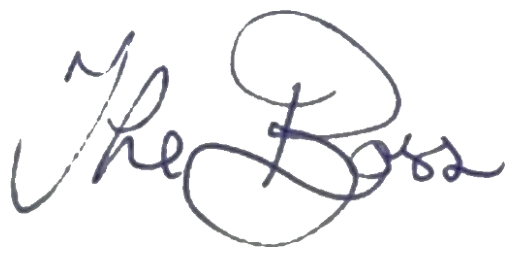

In [250]:
# Step 7 -----------------------------------------------------------

h, w, c = output.shape
targetH = round(h/4)
targetW = round(w/4)

if targetW < 512:
    ratio = targetH / targetW
    targetW = 512
    targetH = round(512 * ratio)

output = cv2.resize(output, dsize=(targetW, targetH))

plt.imshow(output)
plt.axis('off')

output = cv2.cvtColor(output, cv2.COLOR_RGB2BGR)
cv2.imwrite("signature_extract.png", output)